# Protein Classifier using AWD-LSTM

In [2]:
import torch
import torch.nn as nn
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import sklearn.metrics as metrics
from IPython.display import HTML, display

In [3]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

/home/mees/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
dev

'cpu'

In [5]:
torch.manual_seed(42)

In [6]:
HTML("""
<style>
table, th, td {
  border: 1px solid black;
}
</style>
""")

## Usefull Functions

In [7]:
def train_model(epochs, model, train_loader, test_loader, optimizer, criterion):
    r"""Train the resnet18 model.
    
    Train the resnet18 model for `epochs`. Using the
    `optimizer` and the loss function in `criterion`.
    
    Parameters
    ----------
    epochs : int
        Number of epochs to train the model.
    model : torch Model
        Model that is being trained.
    train_loader : torch Dataloader
        Dataloader containing the train data to train the model.
    test_loader : torch Dataloader
        Dataloader containing the test data to validate the model.
    optimizer : torch Optimizer
        Optimizer used to optimize the model.
    criterion : torch.nn Lossfunction
        Loss function used. This loss function has to be minimilized by the model.
    
    Returns
    -------
    torch Model
        The trained model.
    loss_history : array
        Training loss for each epoch.
    val_loss_history : array
        Validation loss for each epoch.
    
    """
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):

        # Inititiate loss variables
        epoch_loss = 0.0
        epoch_val_loss = 0.0

        print(f'Epoch: {str(epoch + 1)}')
        start_time = time.time()

        # Alterate between train and validaton phase
        for phase in ['train', 'val']:

          if phase == 'train':
            model.train(True) # Set model to training mode
            data_loader = train_loader
          else:
            model.train(False) # Set model to evaluate mode
            data_loader = test_loader


          # Loop over the data in batch sizes.
          for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a one input (batch size), and y
            x, y = data
            x = x.squeeze(0) # Squeeze x in the correct shape
            y = y.squeeze(0) # Squeeze y in the correct shape

            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(x)   
            output = output.unsqueeze(0) # For the correct shape
            loss = criterion(output, y)

            # Add loss to each epoch
            if phase == 'train':
                loss.backward()
                optimizer.step()
                epoch_loss = output.shape[0] * loss.item()
            else:
                epoch_val_loss += output.shape[0] * loss.item()

        epoch_loss /= len(train_set)
        epoch_val_loss /= len(test_set)

        loss_history.append(epoch_loss)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch {str(epoch)} MSE Train Loss: {str(epoch_loss)} ; Validation Loss: {str(epoch_val_loss)}.')

        end_time = time.time()
        epoch_time_minutes = (end_time - start_time) / 60
        
        print(f'Epoch duration {str(epoch_time_minutes)} minutes.')
        
    print('Finished Training')
    return model, loss_history, val_loss_history

In [8]:
# Plot the training and validation loss using matplotlib
def show_losses(training_loss, validation_loss):
    r"""Plot graphs with on x-axis epochs and y-axis the loss.

        This graph contains both the `training_loss` and `validation_loss`
        for each epoch.

        Parameters
        ----------
        training_loss : array
            Containing the training loss for each epoch.
        validation_loss : array
            Containing the validation loss for each epoch

        Returns
        -------
        Plot of the two graphs.

    """
    np_loss = np.asarray(training_loss)
    np_val_loss = np.asarray(validation_loss)
    plt.plot(np_loss, label='Train loss')
    plt.plot(np_val_loss, label='Validation loss')
    plt.legend()
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('Epochs')
    plt.show()

In [9]:
# Tokenize the protein sequence (or any sequence) in kmers.
def tokenize(df, protein_seqs_column, kmer_sz, premade_vocab=False):
    
    if not premade_vocab:
        kmers = set()
        # Loop over protein sequences
        for protein_seq in df[protein_seqs_column]:
            # Loop over the whole sequence
            for i in range(len(protein_seq) - (kmer_sz - 1)):
                # Add kmers to the set, thus only unique kmers will remain
                kmers.add(protein_seq[i: i + kmer_sz])

        # Map kmers for one hot-encoding
        kmer_to_id = dict()
        id_to_kmer = dict()

        for ind, kmer in enumerate(kmers):
            kmer_to_id[kmer] = ind
            id_to_kmer[ind] = kmer

        vocab_sz = len(kmers)

        assert vocab_sz == len(kmer_to_id.keys())
    
    else:
        kmer_to_id, id_to_kmer = premade_vocab
        vocab_sz = len(kmer_to_id)
    
    # Tokenize the protein sequence to integers
    tokenized = []
    for i, protein_seq in enumerate(df[protein_seqs_column], 0):
        sequence = []
        
        # If the kmer can't be found these indexes should be deleted
        remove_idxs = []
        
        for i in  range(len(protein_seq) - (kmer_sz -1)):
            # Convert kmer to integer
            kmer = protein_seq[i: i + kmer_sz]
            
            # For some reason, some kmers miss. Thus these sequences have to be removed
            try:
                sequence.append(kmer_to_id[kmer])
            except:
                remove_idxs.append(i)
            
        tokenized.append(sequence)
            
    df['tokenized_seqs'] = tokenized
    
    df.drop(remove_idxs, inplace=True)
    
    return df, vocab_sz, kmer_to_id, id_to_kmer

In [10]:
# Function to show the accuracy of the model.
def accuracy(model, data_loader):
    r"""Calculate accuracy of the model.
    
    Calculates the accuracy of the trained `model`
    for the `data_loader` in the input.
    
    Parameters
    ----------
    model : torch Model
        The trained model.
    data_loader : torch Dataloader
        Torch dataloader containing the samples you want to test the accuracy for.
    
    Returns
    -------
    Prints the accurucy of the `model` for the samples in the `data_loader`
    
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for ind, data in enumerate(data_loader, 0):
            x, y = data
            x = x.squeeze(0) # Squeeze x in the correct shape
            y = y.squeeze(0) # Squeeze y in the correct shape
            
            output = model(x)
            output = output.unsqueeze(0)
            
            _, predicted = torch.max(output.data, 1)

            total += y.size(0)
            correct += (predicted == y).sum().item()

        accuracy = np.round((correct / total * 100), 2)
        print(f'Accuracy of the network is {str(accuracy)}%.')

## Load the data

In [26]:
data_file = Path('/home/mees/Desktop/Machine_Learning/subcellular_location/data/processed/protein_data_2021-04-04.csv')
df = pd.read_csv(data_file, sep=';')
df.head()

,Sequence,Subcellular location [CC],Location
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,"SUBCELLULAR LOCATION: Cytoplasmic vesicle, sec...",Cytoplasm
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,SUBCELLULAR LOCATION: Early endosome {ECO:0000...,Endosome
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,"SUBCELLULAR LOCATION: Cytoplasm, cytoskeleton,...",Cytoplasm
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,SUBCELLULAR LOCATION: Mitochondrion {ECO:00003...,Mitochondrion
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,Cell membrane


In [27]:
df.drop(columns=['Subcellular location [CC]'], inplace=True)
df.head()

,Sequence,Location
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,Cytoplasm
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,Endosome
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,Cytoplasm
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,Mitochondrion
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,Cell membrane


### Tokenize the Data

The data has to be tokenized according to the Language Model trained before, therefore, we have to load in that dictionary.

In [28]:
# Set-up numpy generator for random numbers
random_number_generator = np.random.default_rng(seed=42)
KMER_SIZE = 3

In [29]:
# Load the vocabolary from the Language Model
vocab_save_file = '/home/mees/Desktop/Machine_Learning/subcellular_location/data/interim/LM_vocab.pkl'
vocab = pickle.load(open(vocab_save_file, 'rb'))

In [30]:
# Tokenize the protein sequence
df, vocab_sz, kmer_to_id, id_to_kmer = tokenize(df, 'Sequence', KMER_SIZE, vocab)

In [31]:
df.head()

,Sequence,Location,tokenized_seqs
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,Cytoplasm,"[3884, 8570, 3840, 6832, 2277, 2221, 1020, 904..."
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,Endosome,"[8772, 7207, 1857, 1688, 5461, 3901, 4899, 424..."
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,Cytoplasm,"[1565, 3797, 2513, 516, 1428, 6558, 6568, 7337..."
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,Mitochondrion,"[8939, 2538, 9262, 4438, 2547, 302, 60, 3064, ..."
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,Cell membrane,"[8939, 6897, 6013, 1021, 3034, 2863, 8501, 697..."


In [32]:
len(df)

16614

### Numericalize the label data

In [33]:
# Some fields are NaN, remove these
df.dropna(inplace=True)
len(df)

16614

Create a dictionary to numericalize the labels.

In [34]:
label_dict = {}

for i, label in enumerate(df['Location'].unique(), 0):
    label_dict[label] = i

In [35]:
def numericalizeClass(df, class_column, label_dict, label_column='Label'):
    df[label_column] = df[class_column].map(label_dict)
        
    return df

In [36]:
df = numericalizeClass(df, 'Location', label_dict)
df.head()

,Sequence,Location,tokenized_seqs,Label
0,MTDTVFSNSSNRWMYPSDRPLQSNDKEQLQAGWSVHPGGQPDRQRK...,Cytoplasm,"[3884, 8570, 3840, 6832, 2277, 2221, 1020, 904...",0
1,MDTDSQRSHLSSFTMKLMDKFHSPKIKRTPSKKGKPAEVSVKIPEK...,Endosome,"[8772, 7207, 1857, 1688, 5461, 3901, 4899, 424...",1
2,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,Cytoplasm,"[1565, 3797, 2513, 516, 1428, 6558, 6568, 7337...",0
3,MALPGARARGWAAAARAAQRRRRVENAGGSPSPEPAGRRAALYVHW...,Mitochondrion,"[8939, 2538, 9262, 4438, 2547, 302, 60, 3064, ...",2
4,MALLVDRVRGHWRIAAGLLFNLLVSICIVFLNKWIYVYHGFPNMSL...,Cell membrane,"[8939, 6897, 6013, 1021, 3034, 2863, 8501, 697...",3


In [37]:
label_dict

{'Cytoplasm': 0,
 'Endosome': 1,
 'Mitochondrion': 2,
 'Cell membrane': 3,
 'Nucleus': 4,
 'Endoplasmic reticulum': 5,
 'Secreted': 6,
 'Golgi apparatus': 7,
 'Extracellular': 8,
 'Peroxisome': 9,
 'Lysosome/ Vacuole': 10}

(array([3647.,   95.,  858., 3993., 5462.,  651., 1079.,  316.,  375.,
         138.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

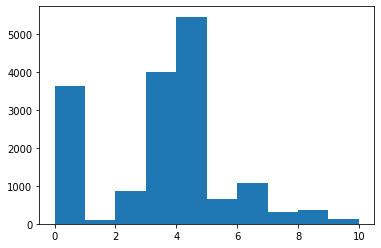

In [38]:
plt.hist(df['Label'])

! It might help to rebalance the classes since classes 0, 3 and 4 are now over represented. Therefore, the model can just default to class 4. Since, if the model predicts class 4 for every sequence it will have an accuracy of around 34% already.

An other point is that the sequence should have some information to work with, according to this paper:
> https://www.nature.com/articles/s41598-019-38746-w

A motif can be in between 3-20 amino acids, thus 1-6/7 kmers. I chose 5 kmers. However training time took way longer in that way.

In [39]:
df['Length'] = df['tokenized_seqs'].str.len()


(array([  3.,  21.,  15.,   5.,  18.,  31.,  57.,  93., 104., 163.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

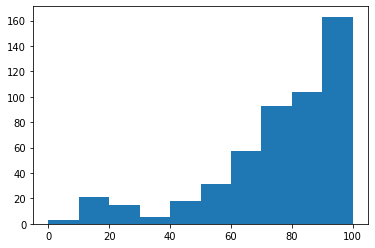

In [43]:
plt.hist(df['Length'], range=(0, 100))

Based on this, and reduce training time. I now choose a sequence length of 50

In [45]:
df = df[df['Length'] >= 50]
len(df)

16552

This only removed about 60 entries.

## Dataset class

In [48]:
class AminoClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, df, num_classes):
        self.df = df
        self.num_classes = num_classes 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x = torch.LongTensor(self.df.iloc[idx]['tokenized_seqs'])
        x = x.to(dev) 
        
        y = torch.LongTensor([self.df.iloc[idx]['Label']])
        y = y.to(dev)
    
        return x, y

## The Protein Classifier

Creating the complete protein from its parts

### AWD-LSTM
Start with the AWD-LSTM, which encodes the protein sequence and is already trained.

I can add more dropout and I should add including the last hidden layers (cell and hidden states).

In [49]:
class WeightDropout(torch.nn.Module):
    "Apply dropout to LSTM's hidden-hidden weights"

    def __init__(self, module, weight_p):
        super(WeightDropout, self).__init__()
        self.module = module
        self.weight_p = weight_p

        # Save the name of the layer weights in a list
        num_layers = module.num_layers
        layer_base_name = 'weight_hh_l'      
        self.layer_weights = [layer_base_name + str(i) for i in range(num_layers)]

        # Make a copy of the weights in weightname_raw
        for weight in self.layer_weights:

            w = getattr(self.module, weight)
            del module._parameters[weight]
            self.module.register_parameter(f'{weight}_raw', torch.nn.Parameter(w))

    def _setweights(self):
        "Apply dropout to the raw weights"
        for weight in self.layer_weights:
            raw_w = getattr(self.module, f'{weight}_raw')
            if self.training:
                w = torch.nn.functional.dropout(raw_w, p=self.weight_p)
            else:
                w = raw_w.clone()
            setattr(self.module, weight, w)

    def forward(self, *args):
        self._setweights()
        return self.module(*args)

In [50]:
class AWD_LSTM(torch.nn.Module):
    def __init__(self, num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, embed_p, input_p, weight_p, batch_sz = 1):
        super(AWD_LSTM, self).__init__()

        # Embedding with droput
        self.encoder = torch.nn.Embedding(vocab_sz, emb_dim)
        self.emb_drop = torch.nn.Dropout(p=embed_p)


        # Dropouts on the inputs and the hidden layers
        self.input_dp = torch.nn.Dropout(p=input_p)
        self.hid_dp = torch.nn.Dropout(p=hidden_p)

        # Create a list of lstm layers with wieghtdropout
        self.lstms = []
        for i in range(num_layers):
            self.lstms.append(
                WeightDropout(nn.LSTM(input_size=emb_dim, hidden_size=hid_sz, num_layers=1), weight_p))
        self.lstms = nn.ModuleList(self.lstms)

        # Decoder
        self.decoder = torch.nn.Linear(hid_sz, vocab_sz)

        # Save all variables        
        self.num_layers = num_layers
        self.vocab_sz = vocab_sz
        self.emb_dim = emb_dim
        self.hid_sz = hid_sz
        self.hidden_p = hidden_p
        self.embed_p = embed_p
        self.input_p = input_p
        self.weight_p = weight_p
        self.batch_sz = batch_sz

        # Initialize hidden layers        
        self.reset_hidden()
        self.last_hiddens = (self.hidden_state, self.cell_state)

    def forward(self, xs):
        """Forward pass AWD-LSTM""" 

        ys = []

        hiddens = self.last_hiddens

        hidden_states = [hiddens]

        for i, lstm in enumerate(self.lstms):

            embed = self.encoder(xs[i])
            embed_dp = self.emb_drop(embed)
            input_dp = self.input_dp(embed_dp)

            hiddens_dp = []

            for hidden_state in hidden_states[i]:
                hiddens_dp.append(self.hid_dp(hidden_state))

            hiddens_dp = tuple(hiddens_dp)
            output, hiddens = lstm(input_dp.view(1, 1, -1), hiddens_dp) 


            det_hiddens = []

            for hidden in hiddens:
                det_hiddens.append(hidden.detach())

            det_hiddens = tuple(det_hiddens)

            hidden_states.append(det_hiddens)


            # Outputs moeten squeezen om de loss toe te kunnen passen, maar moet nog even kijken of de juiste waardes dan wel worden mee genomen
            ys.append(output.squeeze(0))

        y = torch.stack(ys, dim=0)

        self.last_hiddens = hidden_states[-1]

        return y, hidden_states

    def reset_hidden(self):
        self.hidden_state = torch.zeros((1, self.batch_sz, self.hid_sz)).to(dev)
        self.cell_state = torch.zeros((1, self.batch_sz, self.hid_sz)).to(dev)
        self.last_hiddens = (self.hidden_state, self.cell_state)

### SentenceEncoder

This part encodes the whole sequences in seq_lenghts using the pretrained AWD-LSTM language model.

We use the Identity class to replace the decoder in the original AWD-LSTM. 

Finally, the model should not be updated. Therefore, the forward pass is in torch.no_grad().

In [51]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [52]:
class SentenceEncoder(torch.nn.Module):
    
    def __init__(self, seq_len, model):
        super(SentenceEncoder, self).__init__()
        
        self.seq_len = seq_len
        self.model = model
        
    def forward(self, inp):
        
        with torch.no_grad():
            
            inp_size = inp.shape[0]

            # It is nicer to add padding
            max_iterations = int(inp_size / self.seq_len)

            hidden_state_outputs = []
            cell_state_outputs = []
            
            for i in range(0, self.seq_len * max_iterations, self.seq_len):
                _, hidden = self.model(inp[i: i + self.seq_len + 1])
                
                for states in hidden:
                    hidden_state_outputs.append(states[0])
                    cell_state_outputs.append(states[1])
                        
            hidden_state_outputs = torch.cat(hidden_state_outputs, dim = 1)
            cell_state_outputs = torch.cat(cell_state_outputs, dim = 1)

            return (hidden_state_outputs, cell_state_outputs)

### PoolingLinearClassifier

The encoded sequence is needed to be pooled, otherwise the model can not use the information for classification.

Then, the data is normalized using batchnorm.
Dropout is applied to prevent overfitting.
And linear layers with a ReLU activiation are used to classify the pooled protein data.

In [53]:
def pool_encoded_sequence(output):
    r"""Pool the encoded AA sequence and 
    return one vector with the max_pool and avg_pool concatenated"""
    
    hidden_states = output[0].squeeze(0)
    cell_states = output[1].squeeze(0)

    last_hidden_state = hidden_states[-1, :]
    last_cell_state = cell_states[-1, :]

    hidden_state_avg = hidden_states.sum(dim=0) / hidden_states.shape[0]
    cell_state_avg = cell_states.sum(dim=0) / cell_states.shape[0]

    hidden_state_max = hidden_states.max(dim=0)[0]
    cell_state_max = hidden_states.max(dim=0)[0]

    x = torch.cat([last_hidden_state, last_cell_state, hidden_state_avg, cell_state_avg, \
                  hidden_state_max, cell_state_max], 0).unsqueeze(0)  
    
    return x

In [54]:
class PoolingLinearClassifier(torch.nn.Module):
    r"""Pool the outputs from the encoder and classify it."""
    
    def __init__(self, num_classes, batch_sz):
        super(PoolingLinearClassifier, self).__init__()
        
        self.num_classes = num_classes
        self.batch_sz = batch_sz
        
        if batch_sz > 1:
            
            self.layers = nn.Sequential(
                nn.BatchNorm1d(1150 * 6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Dropout(p=0.2, inplace=False),
                nn.Linear(in_features=1150 * 6, out_features=1150, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(1150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Dropout(p=0.1, inplace=False),
                nn.Linear(in_features=1150, out_features=50, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Dropout(p=0.1, inplace=False),
                nn.Linear(in_features=50, out_features=num_classes, bias=True)
            )
        else:
            self.layers = nn.Sequential(
                nn.Dropout(p=0.2, inplace=False),
                nn.Linear(in_features=1150 * 6, out_features=1150, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1, inplace=False),
                nn.Linear(in_features=1150, out_features=50, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1, inplace=False),
                nn.Linear(in_features=50, out_features=num_classes, bias=True)
            )
            
        
    
    def forward(self, inp):
        output_encoder = inp
        pooled_output = pool_encoded_sequence(output_encoder)
        y = self.layers(pooled_output)
        y = y.sum(dim=0)
        
        return y        

### Combine everything in the protein classifier

Combine every class and part in the protein classifier

In [55]:
class proteinClassifier(torch.nn.Module):
    r"""The complete protein classifier"""
    
    def __init__(self, num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, embed_p, input_p, weight_p, seq_len, num_classes, pretrained_file=False):
        super(proteinClassifier, self).__init__()
        
        self.num_layers = num_layers
        self.vocab_sz = vocab_sz
        self.emb_dim = emb_dim
        self.hid_sz = hid_sz
        self.hidden_p = hidden_p
        self.embed_p = embed_p
        self.input_p = input_p
        self.seq_len = seq_len
        self.num_classes = num_classes
        self.batch_size = 1
        
        language_model = AWD_LSTM(num_layers, vocab_sz, emb_dim, hid_sz, hidden_p, embed_p, input_p, weight_p)
        
        if pretrained_file:
            language_mode = torch.load(pretrained_file, map_location=torch.device(dev))
        
        language_model.decoder = Identity()
        
        encoder = SentenceEncoder(seq_len, language_model)
        
        classifier = PoolingLinearClassifier(num_classes, self.batch_size)
        
        
        
        # Change the decoder to do nothing and use the classifier as decoder
        encoder.decoder = Identity()
        
        self.layers = nn.Sequential(encoder, classifier)
        
    def forward(self, inp):
        y = self.layers(inp)
        return y

## Model hyperparameters and train the data

In [56]:
# Hyperparameters
emb_dim = 400 # Embeddding dimension
hid_sz = 1150 # Hidden size
num_layers = 3 # Number of LSTM layers stacked together
seq_len = 5 # Based on paper mentioned above

# Dropout parameters

embed_p = 0.1 # Dropout probability on the embedding
hidden_p = 0.3 # Dropout probability on hidden-to-hidden weight matrices
input_p = 0.3 # Dropout probablity on the LSTM input between LSTMS
weight_p = 0.5 # Dropout probability on LSTM-to-LSTM weight matrices

### Load in the pretrained model

In [57]:
pretrained_model = '/home/mees/Desktop/Machine_Learning/subcellular_location/models/AA_LM_v2.pt'

In [58]:
num_classes = len(label_dict)
num_classes

11

In [59]:
model = proteinClassifier(num_layers, vocab_sz, emb_dim, hid_sz, hidden_p,
                         embed_p, input_p, weight_p, seq_len, num_classes, pretrained_model)
model.to(dev)

proteinClassifier(
  (layers): Sequential(
    (0): SentenceEncoder(
      (model): AWD_LSTM(
        (encoder): Embedding(9317, 400)
        (emb_drop): Dropout(p=0.1, inplace=False)
        (input_dp): Dropout(p=0.3, inplace=False)
        (hid_dp): Dropout(p=0.3, inplace=False)
        (lstms): ModuleList(
          (0): WeightDropout(
            (module): LSTM(400, 1150)
          )
          (1): WeightDropout(
            (module): LSTM(400, 1150)
          )
          (2): WeightDropout(
            (module): LSTM(400, 1150)
          )
        )
        (decoder): Identity()
      )
      (decoder): Identity()
    )
    (1): PoolingLinearClassifier(
      (layers): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=6900, out_features=1150, bias=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=1150, out_features=50, bias=True)
        (5): ReLU(inplace=True)
        (6): Dropout(

## Learning hyperparameters

In [60]:
# Hyperparameters
learning_rate = 0.01
epochs = 10
adam_betas = (0.7, 0.99)

In [61]:
# Costfunction and optimize algorithm
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=adam_betas)

## Train the model

In [62]:
# Load the data in the DataSet
AADataset = AminoClassifierDataset(df, num_classes)

In [63]:
# Split the data in an 80/20% split for training and testing
data_len = len(AADataset)
train_part = int(0.8 * data_len)
test_part = data_len - train_part

train_set, test_set = torch.utils.data.random_split(AADataset, [train_part, test_part])

In [64]:
# Load the data into data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [65]:
trained_model, loss_history, val_loss_history = train_model(epochs, model, train_loader, test_loader, optimizer, criterion)

Epoch: 1


KeyboardInterrupt: 

In [ ]:
show_losses(loss_history, val_loss_history)

In [34]:
save_model_file = '/home/mees/Desktop/Machine_Learning/subcellular_location/models/trained_protein_classifier.pt'
torch.save(model.state_dict, save_model_file)

In [55]:
# Show the accuracy on test data
accuracy(trained_model, test_loader)

Accuracy of the network is 29.52%.


In [56]:
# Show the accuracy on train data
accuracy(trained_model, train_loader)

Accuracy of the network is 29.75%.


In [59]:
with torch.no_grad():
    
    all_predicted = []
    ys = []
    
    for ind, data in enumerate(test_loader, 0):
        x, y = data
        x = x.squeeze(0) # Squeeze x in the correct shape
        y = y.squeeze(0) # Squeeze y in the correct shape

        output = model(x)
        output = output.unsqueeze(0)

        _, predicted = torch.max(output.data, 1)

        all_predicted.append(predicted)
        ys.append(y)

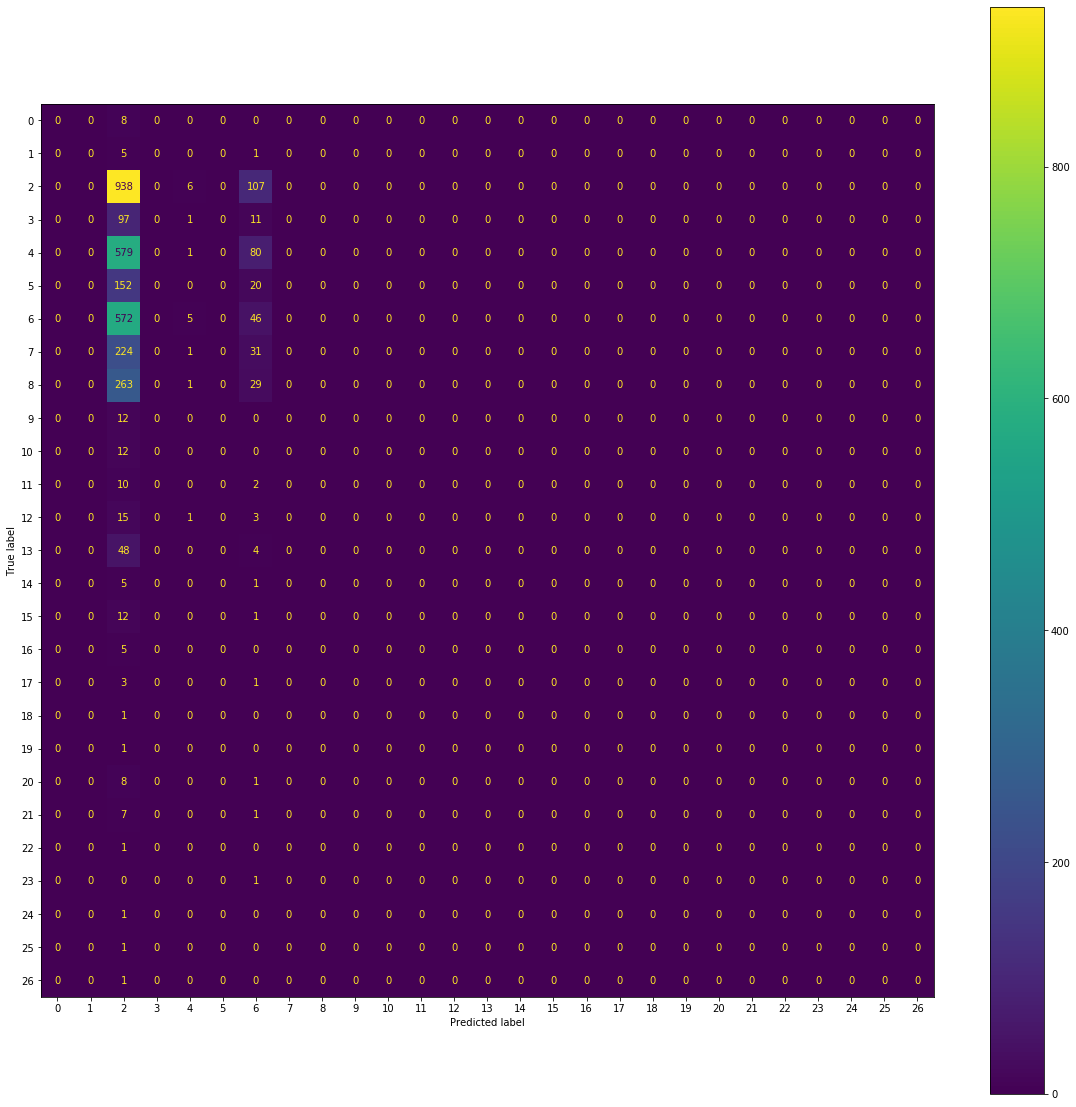

In [63]:
confusion_matrix = metrics.confusion_matrix(ys, all_predicted)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax)

In [65]:
print(label_dict)

{'Membrane': 0, 'Endosome': 1, 'Cytoplasm': 2, 'Mitochondrion': 3, 'pass membrane protein': 4, 'Single': 5, 'Nucleus': 6, 'Cell membrane': 7, 'Secreted': 8, 'Golgi apparatus': 9, 'Cell junction': 10, 'Peroxisome': 11, 'Cell projection': 12, 'Peripheral membrane protein': 13, 'Cytoplasmic vesicle': 14, 'Lysosome': 15, 'Chromosome': 16, 'anchor': 17, 'Endoplasmic reticulum membrane': 18, 'Cytoplasmic granule': 19, 'Cell surface': 20, 'Endoplasmic reticulum': 21, 'Endoplasmic reticulum lumen': 22, 'Melanosome': 23, 'Virion': 24, 'Vesicle': 25, 'Isoform 1': 26, 'Peroxisome matrix': 27, 'Sarcoplasmic reticulum': 28, 'Endomembrane system': 29, 'Membrane raft': 30, 'Midbody': 31, 'Lipid droplet': 32}
